In [1]:
import os
os.chdir("..")

In [13]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# For saving models
import joblib

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("="*60)
print("MODEL DEVELOPMENT NOTEBOOK")
print("="*60)
print("-> All libraries imported successfully!")
print(f"Current date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

MODEL DEVELOPMENT NOTEBOOK
-> All libraries imported successfully!
Current date: 2025-12-13 13:09:03


In [14]:
# load processed data
print("\n" + "="*60)
print("LOADING PROCESSED DATA")
print("="*60)

df = pd.read_csv('data/processed/tb_data_processed_without_feature.csv')

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

print(f"-> Data loaded successfully!")
print(f"\nDataset info:")
print(f"  Shape: {df.shape}")
print(f"  Rows: {df.shape[0]:,}")
print(f"  Columns: {df.shape[1]}")
print(f"  Date range: {df['date'].min()} to {df['date'].max()}")
print(f"  Districts: {df['district'].nunique()}")
print(f"  Missing values: {df.isnull().sum().sum()}")

# Display first few rows
print("\nFirst 3 rows:")
print(df.head(3))


LOADING PROCESSED DATA
-> Data loaded successfully!

Dataset info:
  Shape: (112497, 15)
  Rows: 112,497
  Columns: 15
  Date range: 2021-01-01 00:00:00 to 2024-12-31 00:00:00
  Districts: 77
  Missing values: 0

First 3 rows:
  district       date      co  humidity   nh3   no2     o3    pm10  \
0   Achham 2021-01-01  699.56     31.65  4.48  4.61  41.96  106.54   
1   Achham 2021-01-02  634.19     33.12  6.01  4.12  41.47   82.56   
2   Achham 2021-01-03  491.50     51.24  2.69  3.15  32.96   42.73   

   precipitation  air_pressure   so2  solar_radiation  tb_case  avg_temp  \
0           0.00         96.96  1.19             3.35      1.0     16.87   
1           0.22         96.89  1.43             3.01      0.0     18.18   
2           8.69         96.79  0.76             2.26      0.0     19.49   

   tb_binary  
0          1  
1          0  
2          0  


In [15]:
# define features and target variable
print("\n" + "="*60)
print("PREPARING FEATURES AND TARGET")
print("="*60)

# Columns to drop (non-predictive)
drop_cols = ['date', 'district']

# Target variable
target = 'tb_binary'

# Feature columns (everything except date, district, and target)
feature_cols = [
    'co', 'humidity', 'nh3', 'no2', 'o3', 'pm10',
    'precipitation', 'air_pressure', 'so2', 'solar_radiation', 'avg_temp'
]

# Separate features and target
X = df[feature_cols].copy()
y = df[target].copy()

print(f"-> Features and target prepared!")
print(f"\nFeature matrix (X):")
print(f"  Shape: {X.shape}")
print(f"  Number of features: {len(feature_cols)}")

print(f"\nTarget variable (y):")
print(f"  Shape: {y.shape}")
print(f"  Mean TB cases: {y.mean():.2f}")
print(f"  Min TB cases: {y.min()}")
print(f"  Max TB cases: {y.max()}")
print(f"  Std TB cases: {y.std():.2f}")

print(f"\nFeature names:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:3d}. {col}")


PREPARING FEATURES AND TARGET
-> Features and target prepared!

Feature matrix (X):
  Shape: (112497, 11)
  Number of features: 11

Target variable (y):
  Shape: (112497,)
  Mean TB cases: 0.45
  Min TB cases: 0
  Max TB cases: 1
  Std TB cases: 0.50

Feature names:
    1. co
    2. humidity
    3. nh3
    4. no2
    5. o3
    6. pm10
    7. precipitation
    8. air_pressure
    9. so2
   10. solar_radiation
   11. avg_temp


In [16]:
# Final data quality check
print("\n" + "="*60)
print("DATA QUALITY CHECK")
print("="*60)

# Check for NaN in features
nan_features = X.isnull().sum()
if nan_features.sum() > 0:
    print("# WARNING: NaN values found in features:")
    print(nan_features[nan_features > 0])
else:
    print("-> No NaN values in features")

# Check for NaN in target
if y.isnull().sum() > 0:
    print(f"# WARNING: {y.isnull().sum()} NaN values in target")
else:
    print("-> No NaN values in target")

# Check for infinite values
numeric_X = X.select_dtypes(include=[np.number])

inf_features = np.isinf(numeric_X).sum()
if inf_features.sum() > 0:
    print("# WARNING: Infinite values found in features")
else:
    print("-> No infinite values in features")

# Check data types
print(f"\nData types in features:")
print(X.dtypes.value_counts())

print("\n-> Data quality check complete!")


DATA QUALITY CHECK
-> No NaN values in features
-> No NaN values in target
-> No infinite values in features

Data types in features:
float64    11
Name: count, dtype: int64

-> Data quality check complete!


In [17]:
# Split data into training and testing sets
print("\n" + "="*60)
print("SPLITTING DATA (TEMPORAL SPLIT BY DISTRICT)")
print("="*60)

# 1. Sort by district + date to preserve time-order for each district
df_sorted = df.sort_values(['district', 'date']).reset_index(drop=True)

# 2. Choose test period (all of 2024)
test_start_date = pd.to_datetime('2024-01-01')

# 3. Create boolean masks
train_mask = df_sorted['date'] < test_start_date
test_mask  = df_sorted['date'] >= test_start_date

# 4. Split features and target
X_train = df_sorted.loc[train_mask, feature_cols].copy()
y_train = df_sorted.loc[train_mask, target].copy()

X_test  = df_sorted.loc[test_mask, feature_cols].copy()
y_test  = df_sorted.loc[test_mask, target].copy()

# 5. Split date info (optional but useful)
train_dates = df_sorted.loc[train_mask, 'date']
test_dates  = df_sorted.loc[test_mask, 'date']

print("-> Data split complete!")

# --------------------
# Summary Information
# --------------------
print(f"\nTraining set:")
print(f"  Samples: {X_train.shape[0]:,}")
print(f"  Date range: {train_dates.min()} to {train_dates.max()}")
print(f"  TB cases - Mean: {y_train.mean():.2f}, Min: {y_train.min()}, Max: {y_train.max()}")

print(f"\nTesting set:")
print(f"  Samples: {X_test.shape[0]:,}")
print(f"  Date range: {test_dates.min()} to {test_dates.max()}")
print(f"  TB cases - Mean: {y_test.mean():.2f}, Min: {y_test.min()}, Max: {y_test.max()}")

print(f"\nFeature dimensions:")
print(f"  X_train: {X_train.shape}")
print(f"  X_test: {X_test.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  y_test: {y_test.shape}")



SPLITTING DATA (TEMPORAL SPLIT BY DISTRICT)
-> Data split complete!

Training set:
  Samples: 84,315
  Date range: 2021-01-01 00:00:00 to 2023-12-31 00:00:00
  TB cases - Mean: 0.43, Min: 0, Max: 1

Testing set:
  Samples: 28,182
  Date range: 2024-01-01 00:00:00 to 2024-12-31 00:00:00
  TB cases - Mean: 0.49, Min: 0, Max: 1

Feature dimensions:
  X_train: (84315, 11)
  X_test: (28182, 11)
  y_train: (84315,)
  y_test: (28182,)



VISUALIZING TRAIN-TEST SPLIT


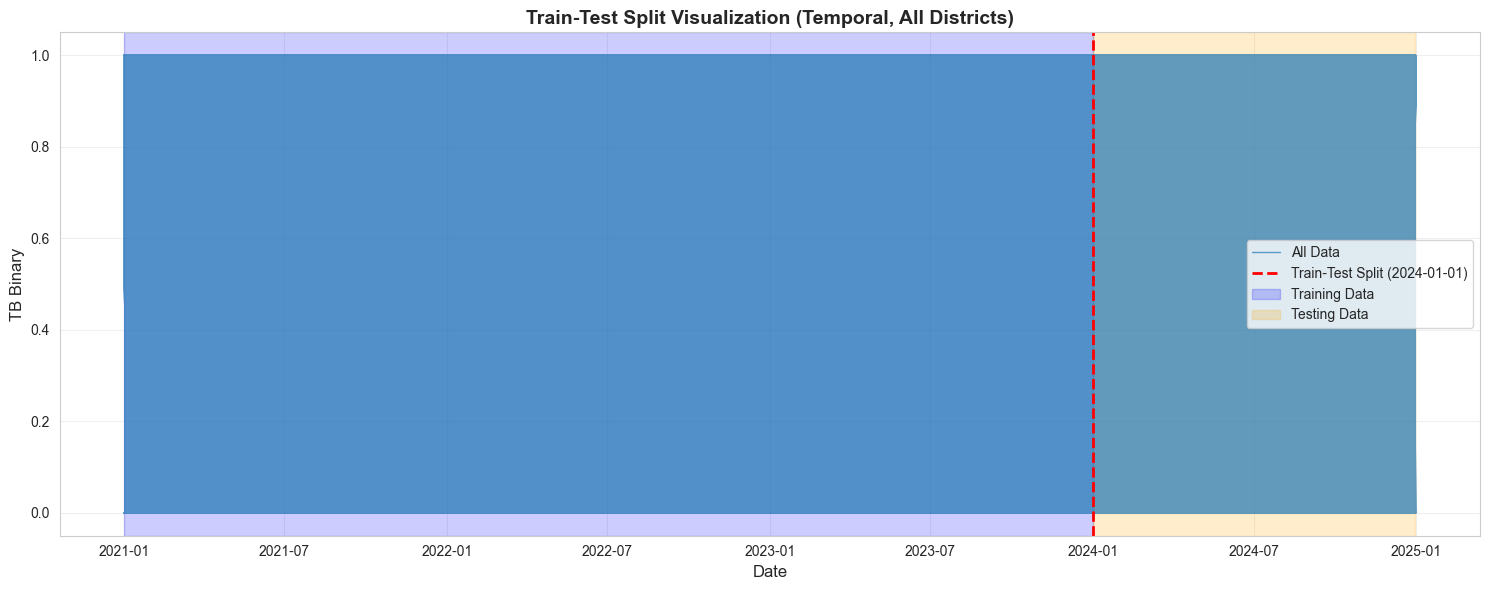

-> Visualization saved to 'figures/train_test_split.png'


In [18]:
# Visualize the train-test split
print("\n" + "="*60)
print("VISUALIZING TRAIN-TEST SPLIT")
print("="*60)

plt.figure(figsize=(15, 6))

# Use the sorted dataframe used for splitting
dates_sorted = df_sorted["date"]
y_sorted = df_sorted["tb_binary"]

# Convert to numpy for plotting
full_dates = dates_sorted.values
full_tb = y_sorted.values

# Plot full TB case timeline (all districts combined)
plt.plot(full_dates, full_tb, linewidth=1, alpha=0.7, label='All Data')

# Train-test split boundary (2024-01-01)
split_date = pd.to_datetime("2024-01-01")
plt.axvline(x=split_date, color='red', linestyle='--', linewidth=2, 
            label=f'Train-Test Split ({split_date.strftime("%Y-%m-%d")})')

# Shade training region
plt.axvspan(dates_sorted.min(), split_date, 
            alpha=0.2, color='blue', label='Training Data')

# Shade testing region
plt.axvspan(split_date, dates_sorted.max(), 
            alpha=0.2, color='orange', label='Testing Data')

plt.title('Train-Test Split Visualization (Temporal, All Districts)', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('TB Binary', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save figure
plt.savefig('figures/train_test_split.png', dpi=300, bbox_inches='tight')
plt.show()

print("-> Visualization saved to 'figures/train_test_split.png'")


In [19]:
# ============================================================
# MODEL 1: CATBOOST CLASSIFIER (Weighted for Class Imbalance)
# ============================================================

print("\n" + "="*70)
print("MODEL 1: CATBOOST CLASSIFIER (Weighted)")
print("="*70)

from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# ----------------------------
# 1. Detect categorical features
# ----------------------------
cat_features = [
    i for i, col in enumerate(X_train.columns)
    if X_train[col].dtype == "object"
]
print("Categorical features:", cat_features, [X_train.columns[i] for i in cat_features])

# ----------------------------
# 2. Compute class weights (handle imbalance)
# ----------------------------
from sklearn.utils.class_weight import compute_class_weight
classes = np.array([0, 1])
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
sample_weights = y_train.map({0: class_weights[0], 1: class_weights[1]})
print(f"Class weights: {dict(zip(classes, class_weights))}")

# ----------------------------
# 3. Prepare CatBoost Pool
# ----------------------------
train_pool = Pool(X_train, y_train, cat_features=cat_features, weight=sample_weights)
test_pool  = Pool(X_test,  y_test,  cat_features=cat_features)

# ----------------------------
# 4. Initialize CatBoost Classifier
# ----------------------------
cat_model = CatBoostClassifier(
    iterations=1500,
    learning_rate=0.03,
    depth=8,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    od_wait=50,        # early stopping
    verbose=200,
    task_type="GPU"    # or "CPU"
)

# ----------------------------
# 5. Train model
# ----------------------------
print("\n... Training CatBoost Classifier ...")
cat_model.fit(train_pool, eval_set=test_pool, use_best_model=True)

print("\n-> Training complete!")

# ----------------------------
# 6. Predictions
# ----------------------------
y_pred_train = cat_model.predict(X_train)
y_pred_test  = cat_model.predict(X_test)
y_pred_proba_test = cat_model.predict_proba(X_test)[:, 1]  # probability of class 1

# ----------------------------
# 7. Evaluate performance
# ----------------------------
def classification_metrics(y_true, y_pred, y_proba=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba) if y_proba is not None else None
    return acc, prec, rec, f1, auc

acc, prec, rec, f1, auc = classification_metrics(y_test, y_pred_test, y_pred_proba_test)

print("\nTesting Set Performance (CatBoost Classifier):")
print(f"  Accuracy : {acc:.4f}")
print(f"  Precision: {prec:.4f}")
print(f"  Recall   : {rec:.4f}")
print(f"  F1-score : {f1:.4f}")
if auc is not None:
    print(f"  ROC-AUC  : {auc:.4f}")

# Optional: confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
print("\nConfusion Matrix:")
print(cm)



MODEL 1: CATBOOST CLASSIFIER (Weighted)
Categorical features: [] []
Class weights: {np.int64(0): np.float64(0.884936711517874), np.int64(1): np.float64(1.1494574108408768)}

... Training CatBoost Classifier ...


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7575130	best: 0.7575130 (0)	total: 16.3ms	remaining: 24.4s
200:	test: 0.7824593	best: 0.7824593 (200)	total: 1.61s	remaining: 10.4s
400:	test: 0.7845320	best: 0.7845805 (390)	total: 3.23s	remaining: 8.86s
600:	test: 0.7853301	best: 0.7853561 (591)	total: 4.97s	remaining: 7.43s
bestTest = 0.7853560746
bestIteration = 591
Shrink model to first 592 iterations.

-> Training complete!

Testing Set Performance (CatBoost Classifier):
  Accuracy : 0.7200
  Precision: 0.7571
  Recall   : 0.6338
  F1-score : 0.6900
  ROC-AUC  : 0.7854

Confusion Matrix:
[[11508  2817]
 [ 5075  8782]]


In [20]:
# Function to compute MAPE safely
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    
print("\nTesting Set Performance (CatBoost):")
print(f"  MAE:  {mae_test:.4f}")
print(f"  RMSE: {rmse_test:.4f}")
print(f"  R²:   {r2_test:.4f}")
mape_rf = mean_absolute_percentage_error(y_test, y_pred_cat_test)

# Optional interpretability: pseudo-accuracy
accuracy_rf = 100 - mape_rf

print(f"  MAPE:  {mape_rf:.2f}%")
print(f"  Accuracy (100 - MAPE): {accuracy_rf:.2f}%")
    


Testing Set Performance (CatBoost):


NameError: name 'mae_test' is not defined

In [21]:
# ============================================================
# MODEL 2: XGBOOST REGRESSOR
# ============================================================

from sklearn.preprocessing import LabelEncoder

X_train_enc = X_train.copy()
X_test_enc  = X_test.copy()

for col in X_train_enc.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X_train_enc[col] = le.fit_transform(X_train_enc[col])
    X_test_enc[col]  = le.transform(X_test_enc[col])

print("\n" + "="*70)
print("MODEL 2: XGBOOST REGRESSOR")
print("="*70)

from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    tree_method='hist'
)
print("\n... Training XGBoost model ...")
xgb_model.fit(X_train_enc, y_train)

print("\n-> Training complete!")

y_pred_xgb = xgb_model.predict(X_test_enc)

# Performance metrics
mae = mean_absolute_error(y_test, y_pred_xgb)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2 = r2_score(y_test, y_pred_xgb)

print("\nSample predictions (first 5):")
print("  Actual:    ", y_test.iloc[:20].values)
print("  Predicted: ", y_pred_xgb[:20])
print("\nTesting Set Performance (XGBoost):")

print(f"  MAE:  {mae:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  R²:   {r2:.4f}")



MODEL 2: XGBOOST REGRESSOR

... Training XGBoost model ...

-> Training complete!

Sample predictions (first 5):
  Actual:     [0 0 0 0 1 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0]
  Predicted:  [0.35303298 0.33885273 0.34631538 0.37758517 0.49648494 0.22155945
 0.3607974  0.39365792 0.36072442 0.36761218 0.48492208 0.3777019
 0.37062326 0.2368302  0.33311415 0.35082698 0.36470953 0.36040527
 0.38376054 0.2776999 ]

Testing Set Performance (XGBoost):
  MAE:  0.3714
  RMSE: 0.4400
  R²:   0.2253


In [25]:
# ===============================
# RANDOM FOREST CLASSIFIER (tb_binary)
# ===============================
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# ----------------------------
# 1. Initialize Random Forest Classifier
# ----------------------------
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    random_state=42,
    class_weight='balanced',  # handle any imbalance automatically
    n_jobs=-1
)

# ----------------------------
# 2. Train model
# ----------------------------
rf_model.fit(X_train, y_train)

# ----------------------------
# 3. Predictions
# ----------------------------
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]  # probability for ROC-AUC

# ----------------------------
# 4. Classification metrics
# ----------------------------
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)

print("\nRandom Forest Classifier Metrics:")
print(f"  Accuracy : {acc:.4f}")
print(f"  Precision: {prec:.4f}")
print(f"  Recall   : {rec:.4f}")
print(f"  F1-score : {f1:.4f}")
print(f"  ROC-AUC  : {roc_auc:.4f}")
print("  Confusion Matrix:\n", cm)



Random Forest Classifier Metrics:
  Accuracy : 0.7131
  Precision: 0.7829
  Recall   : 0.5763
  F1-score : 0.6639
  ROC-AUC  : 0.7834
  Confusion Matrix:
 [[12110  2215]
 [ 5871  7986]]


In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

print("\n" + "="*60)
print("MODEL 3: RANDOM FOREST REGRESSOR")
print("="*60)

# One-hot encode categorical columns
X_train_encoded = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test_encoded  = pd.get_dummies(X_test,  columns=cat_cols, drop_first=True)

# Ensure train and test have the same columns
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Initialize the model
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# Fit the model
rf_model.fit(X_train_encoded, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test_encoded)


print("\n" + "="*60)
print("Prediction completed")
print("="*60)


MODEL 3: RANDOM FOREST REGRESSOR


KeyError: "None of [Index(['season'], dtype='object')] are in the [columns]"

In [ ]:
# ----------------------------
# 1. Import metrics
# ----------------------------
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# ----------------------------
# 2. Define MAPE function
# ----------------------------
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0  # avoid division by zero
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# ----------------------------
# 3. Compute regression metrics
# ----------------------------
mae = mean_absolute_error(y_test, y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2 = r2_score(y_test, y_pred_rf)
mape = mean_absolute_percentage_error(y_test, y_pred_rf)
accuracy = 100 - mape  # approximate "accuracy" for regression

# ----------------------------
# 4. Print results
# ----------------------------
print("\nRandom Forest Regressor Performance on Test Set:")
print(f"  MAE:  {mae:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  R²:   {r2:.4f}")
print(f"  MAPE: {mape:.2f}%")
print(f"  Accuracy (100 - MAPE): {accuracy:.2f}%")


In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # perfect line
plt.xlabel('Actual TB cases')
plt.ylabel('Predicted TB cases')
plt.title('Random Forest Predictions vs Actual')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Sort by time
df = df.sort_values('date')

# Select features for RNN
features = ['tb_case', 'season']  # you can add more numeric features if available
X = df[features]

# One-hot encode categorical features
cat_cols = ['season', 'district']
encoder = OneHotEncoder(sparse_output=False)  # use sparse_output instead of sparse
X_cat = encoder.fit_transform(df[cat_cols])
X_numeric = df.drop(columns=cat_cols + ['date'])
X_combined = np.hstack([X_numeric.values, X_cat])

y = df['tb_case'].values

# Split into train/test (last 20% for testing)
train_size = int(len(df)*0.8)
X_train, X_test = X_combined[:train_size], X_combined[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# Fit ARIMA on training tb_case
arima_order = (1,0,1)
arima_model = ARIMA(y_train, order=arima_order)
arima_fit = arima_model.fit()

# Forecast
arima_train_pred = arima_fit.predict(start=0, end=len(y_train)-1)
arima_test_pred = arima_fit.predict(start=len(y_train), end=len(y)-1)

# Residuals
residuals = np.concatenate([y_train - arima_train_pred, y_test - arima_test_pred])


# Scale input features for RNN
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_combined)

# Scale residuals
scaler_res = MinMaxScaler(feature_range=(0,1))
residuals_scaled = scaler_res.fit_transform(residuals.reshape(-1,1))


def create_sequences(features, residuals, seq_length=5):
    X_seq, y_seq = [], []
    for i in range(len(features) - seq_length):
        X_seq.append(features[i:i+seq_length])
        y_seq.append(residuals[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 5
X_seq, y_seq = create_sequences(X_scaled, residuals_scaled, seq_length)

# Split sequences
X_train_rnn = X_seq[:train_size-seq_length]
y_train_rnn = y_seq[:train_size-seq_length]
X_test_rnn = X_seq[train_size-seq_length:]
y_test_rnn = y_seq[train_size-seq_length:]

# Shape: [samples, timesteps, features]
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, X_train_rnn.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train
history = model.fit(
    X_train_rnn, y_train_rnn, 
    epochs=50, batch_size=16, validation_split=0.1, verbose=1
)


# Predict residuals
rnn_pred_scaled = model.predict(X_test_rnn)
rnn_pred = scaler_res.inverse_transform(rnn_pred_scaled)

# Final hybrid prediction
arima_test_for_rnn = arima_test_pred[:len(rnn_pred)]
hybrid_pred = arima_test_for_rnn + rnn_pred.flatten()

# Evaluate
mae_hybrid = mean_absolute_error(y_test[:len(hybrid_pred)], hybrid_pred)
rmse_hybrid = np.sqrt(mean_squared_error(y_test[:len(hybrid_pred)], hybrid_pred))
r2_hybrid = r2_score(y_test[:len(hybrid_pred)], hybrid_pred)

print("\nHybrid Multi-Feature ARIMA-RNN Performance:")
print(f"MAE: {mae_hybrid:.4f}")
print(f"RMSE: {rmse_hybrid:.4f}")
print(f"R²: {r2_hybrid:.4f}")


In [ ]:
# SVR MODEL
# Train Support Vector Regression
print("\n" + "="*70)
print("MODEL 2: SUPPORT VECTOR REGRESSION (SVR)")
print("="*70)

# Initialize SVR model
svr_model = SVR(
    kernel='rbf',           # Radial basis function kernel
    C=10,                   # Regularization parameter
    epsilon=0.1,            # Epsilon in epsilon-SVR model
    gamma='scale',          # Kernel coefficient
    cache_size=1000,        # Cache size in MB
    verbose=False
)

print("Model configuration:")
print(f"  kernel: {svr_model.kernel}")
print(f"  C: {svr_model.C}")
print(f"  epsilon: {svr_model.epsilon}")
print(f"  gamma: {svr_model.gamma}")

# Train model (SVR NEEDS scaled data!)
print("\n... Training SVR model...")
print("   (This may take a while for large datasets...)")
start_time = time.time()

svr_model.fit(X_train_scaled, y_train)

training_time = time.time() - start_time
print(f"-> Training complete! Time taken: {training_time:.2f} seconds")

# Make predictions
print("\n... Making predictions...")
y_pred_svr_train = svr_model.predict(X_train_scaled)
y_pred_svr_test = svr_model.predict(X_test_scaled)

print("-> Predictions complete!")
print(f"  Training predictions: {y_pred_svr_train.shape}")
print(f"  Testing predictions: {y_pred_svr_test.shape}")
print(f"\nSample predictions (first 5):")
print(f"  Actual:    {y_test.iloc[:5].values}")
print(f"  Predicted: {y_pred_svr_test[:5]}")

print(f"\nNumber of support vectors: {len(svr_model.support_)}")

In [ ]:
# Cell 11: Train Backpropagation Neural Network
print("\n" + "="*70)
print("MODEL 3: BACKPROPAGATION NEURAL NETWORK (MLP)")
print("="*70)

# Initialize BP Neural Network (Multi-Layer Perceptron)
bp_model = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32),  # 3 hidden layers
    activation='relu',                  # ReLU activation function
    solver='adam',                      # Adam optimizer
    learning_rate='adaptive',           # Adaptive learning rate
    learning_rate_init=0.001,          # Initial learning rate
    max_iter=500,                       # Maximum epochs
    batch_size='auto',                  # Batch size
    random_state=42,
    early_stopping=True,                # Stop if no improvement
    validation_fraction=0.1,            # 10% for validation
    n_iter_no_change=20,               # Patience
    verbose=True                        # Show progress
)

print("Model configuration:")
print(f"  hidden_layer_sizes: {bp_model.hidden_layer_sizes}")
print(f"  activation: {bp_model.activation}")
print(f"  solver: {bp_model.solver}")
print(f"  learning_rate_init: {bp_model.learning_rate_init}")
print(f"  max_iter: {bp_model.max_iter}")
print(f"  early_stopping: {bp_model.early_stopping}")

# Train model (Neural Network NEEDS scaled data!)
print("\n... Training BP Neural Network...")
print("   (Progress will be shown below...)\n")
start_time = time.time()

bp_model.fit(X_train_scaled, y_train)

training_time = time.time() - start_time
print(f"\n-> Training complete! Time taken: {training_time:.2f} seconds")
print(f"   Number of iterations: {bp_model.n_iter_}")
print(f"   Final training loss: {bp_model.loss_:.6f}")

# Make predictions
print("\n... Making predictions...")
y_pred_bp_train = bp_model.predict(X_train_scaled)
y_pred_bp_test = bp_model.predict(X_test_scaled)

print("-> Predictions complete!")
print(f"  Training predictions: {y_pred_bp_train.shape}")
print(f"  Testing predictions: {y_pred_bp_test.shape}")
print(f"\nSample predictions (first 5):")
print(f"  Actual:    {y_test.iloc[:5].values}")
print(f"  Predicted: {y_pred_bp_test[:5]}")

In [ ]:
# Save all trained models
print("\n" + "="*60)
print("SAVING TRAINED MODELS")
print("="*60)

# Create models directory if it doesn't exist
import os
os.makedirs('models', exist_ok=True)

# Save models
joblib.dump(rf_model, 'models/random_forest_model.pkl')
print("-> Random Forest model saved: 'models/random_forest_model.pkl'")

joblib.dump(svr_model, 'models/svr_model.pkl')
print("-> SVR model saved: 'models/svr_model.pkl'")

joblib.dump(bp_model, 'models/bp_neural_network_model.pkl')
print("-> BP Neural Network model saved: 'models/bp_neural_network_model.pkl'")

joblib.dump(scaler, 'models/scaler.pkl')
print("-> Scaler saved: 'models/scaler.pkl'")

print("\n" + "="*60)
print("ALL MODELS SAVED SUCCESSFULLY!")
print("="*60)

In [ ]:
# Save predictions for evaluation
print("\n" + "="*60)
print("SAVING PREDICTIONS")
print("="*60)

# Create results directory
os.makedirs('data/results', exist_ok=True)

# Create predictions DataFrame
predictions_df = pd.DataFrame({
    'date': test_dates.values,
    'actual': y_test.values,
    'rf_predicted': y_pred_rf_test,
    'svr_predicted': y_pred_svr_test,
    'bp_predicted': y_pred_bp_test
})

# Save to CSV
predictions_df.to_csv('data/results/model_predictions.csv', index=False)
print("✅ Predictions saved to 'data/results/model_predictions.csv'")

print(f"\nPredictions summary:")
print(predictions_df.head(10))

In [ ]:
# Quick performance preview (detailed evaluation in next notebook)
print("\n" + "="*70)
print("QUICK PERFORMANCE PREVIEW")
print("="*70)

def quick_metrics(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{model_name}:")
    print(f"  MAE:  {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²:   {r2:.4f}")

print("Testing Set Performance:")
quick_metrics(y_test, y_pred_rf_test, "Random Forest")
quick_metrics(y_test, y_pred_svr_test, "SVR")
quick_metrics(y_test, y_pred_bp_test, "BP Neural Network")

print("\n" + "="*70)
